In [1]:
import pandas as pd
import numpy as np

account=pd.read_parquet('account.gzip') 
card_dev=pd.read_parquet('card_dev.gzip') 
client=pd.read_parquet('client.gzip') 
disp=pd.read_parquet('disp.gzip') 
district=pd.read_parquet('district.gzip') 
loan_dev=pd.read_parquet('loan_dev.gzip') 
trans_dev=pd.read_parquet('trans_dev.gzip')

# Análise descritiva Cliente
## Merging tables & Feature Engineering
### cliente + disp

In [2]:
client_d=client.merge(disp,left_on='client_id',right_on='client_id',how='inner')

In [3]:
print(client.shape)
print(client_d.shape)

(5369, 4)
(5369, 7)


### cliente + disp + card

In [4]:
client_dc=client_d.merge(card_dev,left_on='disp_id',right_on='disp_id',how='left',suffixes=('_disp', '_card'))
client_dc.type_disp.value_counts()

OWNER        4500
DISPONENT     869
Name: type_disp, dtype: int64

In [5]:
cli_cartao=client_dc.loc[client_dc.card_id>=0,'account_id']
client_dc.loc[client_dc.account_id.isin(cli_cartao),'card']=1
client_dc.loc[~client_dc.account_id.isin(cli_cartao),'card']=0

print('Contas com cartão que têm 2o tit:',
len(client_dc.loc[(client_dc.card==1)&(client_dc.type_disp=='DISPONENT')]))

Contas com cartão que têm 2o tit: 31


### cliente + disp + card + account

In [6]:
client_dca=client_dc.merge(account,left_on='account_id',right_on='account_id',how='left',suffixes=('_cli', '_ac'))

In [7]:
client_dca=client_dca.loc[client_dca.ac_date<='1996-12-31']

### cliente + disp + card + account + loan

In [8]:
client_dcal=client_dca.merge(loan_dev,left_on='account_id',right_on='account_id',how='left')

In [9]:
cli_loan=client_dcal.loc[client_dcal.loan_id>=0,'account_id']
client_dcal.loc[client_dcal.account_id.isin(cli_loan),'loan']=1
client_dcal.loc[~client_dcal.account_id.isin(cli_loan),'loan']=0

#print('Contas com loan que têm 2o tit:',
#len(client_dcal.loc[(client_dcal.loan==1)&(client_dcal.type_disp=='DISPONENT')]))

In [10]:
client_dcal.columns

Index(['client_id', 'district_id_cli', 'sex', 'birth_date', 'disp_id',
       'account_id', 'type_disp', 'card_id', 'type_card', 'issued_date',
       'card', 'district_id_ac', 'frequency', 'ac_date', 'loan_id', 'amount',
       'duration', 'payments', 'status', 'loan_date', 'loan'],
      dtype='object')

In [11]:
#para não duplicar resultados
client_dcal.loc[client_dcal.type_disp=='DISPONENT', ['amount',
       'duration', 'payments', 'status', 'loan_date']]=np.nan
client_dcal.loc[client_dcal.type_disp=='DISPONENT', 'loan']=0

#Nr produtos
client_dcal['nb_prod']=client_dcal['card']+client_dcal['loan']

In [12]:
#organizar os dados
#apagar dados desnecessários
client_dcal=client_dcal[['client_id', 'disp_id', 'account_id', 'district_id_cli', 'district_id_ac', 
                         'ac_date', 'birth_date', 'issued_date', 'loan_date',
                         'type_disp', 'type_card', 'sex', 'frequency', 'amount',
                         'duration', 'payments', 'card', 'loan', 'nb_prod', 'status']]

### cliente + disp + card + account + loan + district

In [13]:
client_dcald=client_dcal.merge(district, left_on='district_id_cli',right_on='code',how='left')

client_dcald.loc[client_dcald.district_id_ac!=client_dcald.district_id_cli,'dif_district']=1
client_dcald.loc[client_dcald.district_id_ac==client_dcald.district_id_cli,'dif_district']=0

client_dcald.drop(['code'],axis=1,inplace=True)

In [14]:
client_dcald.columns

Index(['client_id', 'disp_id', 'account_id', 'district_id_cli',
       'district_id_ac', 'ac_date', 'birth_date', 'issued_date', 'loan_date',
       'type_disp', 'type_card', 'sex', 'frequency', 'amount', 'duration',
       'payments', 'card', 'loan', 'nb_prod', 'status', 'name', 'region',
       'no_inhabitants', 'no_municipalities_with_inhabitants_499',
       'no_municipalities_inhabitants_500_1999',
       'no_municipalities_with_inhabitants_2000_9999',
       'no_municipalities_with_inhabitants_10000', 'no_cities',
       'ratio_urban_inhabitants', 'average_salary', 'unemploymant_rate_95',
       'unemploymant_rate_96', 'no_enterpreneurs_per_1000_inhabitants',
       'no_commited_crimes_95', 'no_commited_crimes_96', 'dif_district'],
      dtype='object')

### cliente + disp + card + account + loan + district + info trans

In [15]:
trans_dev['generation']= trans_dev['trans_date'].dt.to_period('M').dt.strftime('%Y-%m-01')

#### Salário médio mensal & Nr meses (trans)

In [16]:
# VER MELHOR MAIS À FRENTE
gb_wage=trans_dev.loc[trans_dev.operation=='collection from another bank'].groupby('account_id').agg({'trans_date':['max','min'], 'amount':'sum'}).reset_index()
gb_wage.columns=['account_id','trans_date_max','trans_date_min', 'rend_sum']

In [17]:
gb_wage['Nr_meses']=1+((gb_wage.trans_date_max - gb_wage.trans_date_min)/np.timedelta64(1, 'M')).astype(int)
gb_wage['avg_wage_trans']=gb_wage.rend_sum/gb_wage.Nr_meses

In [18]:
client_final=client_dcald.merge(gb_wage[['account_id','rend_sum']], left_on='account_id',right_on='account_id',how='left')

In [19]:
client_final['max_date']=pd.to_datetime('1996-12-31')
client_final['max_date_temp']=client_final[['loan_date','max_date']].min(axis=1)
client_final['meses_trans']=1+((client_final.max_date_temp - client_final.ac_date)/np.timedelta64(1, 'M')).astype(int)
client_final.drop(['max_date_temp'],axis=1,inplace=True)

client_final['avg_wage_trans']=client_final.rend_sum/client_final.meses_trans

In [20]:
client_final.loc[(client_final.type_disp=='DISPONENT') & (client_final.avg_wage_trans>0),['account_id','type_disp','average_salary','avg_wage_trans']].head()

,account_id,type_disp,average_salary,avg_wage_trans
2,2,DISPONENT,12541,4736.085106
49,61,DISPONENT,10177,3910.378378
52,63,DISPONENT,8620,2512.000000
71,80,DISPONENT,9425,3166.875000
78,86,DISPONENT,10673,3243.000000


In [21]:
#Assumindo que o salário é do 1o tit
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_wage_trans']=np.nan

#### Gastos fixos

In [22]:
# VER MELHOR MAIS À FRENTE
gb_gastos1=trans_dev.loc[(trans_dev.operation=='remittance to another bank')|(trans_dev.k_symbol=='payment for statement')].groupby('account_id').agg({'trans_date':['max','min'], 'amount':'sum'}).reset_index()
gb_gastos1.columns=['account_id','trans_date_max','trans_date_min', 'rend_sum']

In [23]:
gb_gastos1['Nr_meses']=1+((gb_gastos1.trans_date_max - gb_gastos1.trans_date_min)/np.timedelta64(1, 'M')).astype(int)
gb_gastos1['avg_fout_trans']=gb_gastos1.rend_sum/gb_gastos1.Nr_meses

In [24]:
gb_gastos2=trans_dev.loc[(trans_dev.operation=='remittance to another bank')|(trans_dev.k_symbol.isin(['payment for statement','household','insurance payment']))].groupby('account_id').agg({'amount':'sum'}).reset_index()
gb_gastos2.columns=['account_id','fout_sum']

In [25]:
client_final=client_final.merge(gb_gastos2[['account_id','fout_sum']], left_on='account_id',right_on='account_id',how='left')
client_final['avg_fout_trans']=client_final.fout_sum/client_final.meses_trans

In [26]:
#para não duplicar gastos
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_fout_trans']=np.nan

#### Balanço (proveitos mais gastos) medio mensal

In [27]:
gb_balanco=trans_dev.groupby(['account_id','type']).agg({'amount':'sum'}).reset_index()
gb_balanco.columns=['account_id','type','balance_sum']

gb_balanco.loc[gb_balanco.type!='credit','balance_sum']=-gb_balanco.loc[gb_balanco.type!='credit','balance_sum']

In [28]:
gb_balancof=gb_balanco.groupby(['account_id']).agg({'balance_sum':'sum'}).reset_index()

In [29]:
client_final=client_final.merge(gb_balancof, left_on='account_id',right_on='account_id',how='left')
client_final['avg_balance']=client_final.balance_sum/client_final.meses_trans

#### Nr e Mt transações mensais negativas

In [30]:
gb_nr=trans_dev.loc[trans_dev.type!='credit'].groupby(['account_id']).agg({'amount':['count','sum']}).reset_index()
gb_nr.columns=['account_id','nr_trans','sum_trans']

In [31]:
client_final=client_final.merge(gb_nr, left_on='account_id',right_on='account_id',how='left')
client_final['avg_nr_ntrans']=client_final['nr_trans']/client_final['meses_trans']
client_final['avg_amt_ntrans']=client_final['sum_trans']/client_final['meses_trans']
client_final.drop(['nr_trans','sum_trans'],axis=1,inplace=True)

In [32]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_nr_ntrans']=np.nan
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_amt_ntrans']=np.nan

#### Nr e Mt transações mensais positivas

In [33]:
gb_nr=trans_dev.loc[trans_dev.type=='credit'].groupby(['account_id']).agg({'amount':['count','sum']}).reset_index()
gb_nr.columns=['account_id','nr_trans','sum_trans']

In [34]:
client_final=client_final.merge(gb_nr, left_on='account_id',right_on='account_id',how='left')
client_final['avg_nr_ptrans']=client_final['nr_trans']/client_final['meses_trans']
client_final['avg_amt_ptrans']=client_final['sum_trans']/client_final['meses_trans']
client_final.drop(['nr_trans','sum_trans'],axis=1,inplace=True)

In [35]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_nr_ptrans']=np.nan
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_amt_ptrans']=np.nan

#### Pagamentos de seguro

In [36]:
gb_ins=trans_dev.loc[trans_dev.k_symbol=='insurrance payment'].groupby('account_id').agg({'amount':'sum'}).reset_index()
gb_ins.columns=['account_id','sum_ins']

client_final=client_final.merge(gb_ins, left_on='account_id',right_on='account_id',how='left')
client_final['avg_ins']=client_final['sum_ins']/client_final['meses_trans']
client_final.drop(['sum_ins'],axis=1,inplace=True)

In [37]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_ins']=np.nan

#### Ganhos de juros

In [38]:
gb_int=trans_dev.loc[trans_dev.k_symbol=='interest credited'].groupby('account_id').agg({'amount':'sum'}).reset_index()
gb_int.columns=['account_id','sum_interest']

client_final=client_final.merge(gb_int, left_on='account_id',right_on='account_id',how='left')
client_final['avg_interest']=client_final['sum_interest']/client_final['meses_trans']
client_final.drop(['sum_interest'],axis=1,inplace=True)

In [39]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_interest']=np.nan

#### Ganhos de pensão

In [40]:
gb_pen=trans_dev.loc[trans_dev.k_symbol=='old-age pension'].groupby('account_id').agg({'amount':'sum'}).reset_index()
gb_pen.columns=['account_id','sum_pen']

client_final=client_final.merge(gb_pen, left_on='account_id',right_on='account_id',how='left')
client_final['avg_pension']=client_final['sum_pen']/client_final['meses_trans']
client_final.drop(['sum_pen'],axis=1,inplace=True)

In [41]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_pension']=np.nan

#### Pagamentos da casa

In [42]:
gb_house=trans_dev.loc[trans_dev.k_symbol=='household'].groupby('account_id').agg({'amount':'sum'}).reset_index()
gb_house.columns=['account_id','sum_house']

client_final=client_final.merge(gb_house, left_on='account_id',right_on='account_id',how='left')
client_final['avg_house']=client_final['sum_house']/client_final['meses_trans']
client_final.drop(['sum_house'],axis=1,inplace=True)

In [43]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_house']=np.nan

#### Despesas com cartão

In [44]:
gb_ncard=trans_dev.loc[trans_dev.operation=='credit card withdrawal'].groupby('account_id').agg({'amount':'sum'}).reset_index()
gb_ncard.columns=['account_id','sum_ncard']

client_final=client_final.merge(gb_ncard, left_on='account_id',right_on='account_id',how='left')
client_final['avg_ncard']=client_final['sum_ncard']/client_final['meses_trans']
client_final.drop(['sum_ncard'],axis=1,inplace=True)

In [45]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', 'avg_ncard']=np.nan

#### Despesas do banco

In [46]:
map1={'monthly issuance':14.6,'weekly issuance':30.0,'issuance after transaction':100.0}
client_final['bank_fee']=client_final['frequency'].replace(map1)

#### Age

In [47]:
client_final['Age']=((client_final.ac_date - client_final.birth_date)/np.timedelta64(1, 'Y')).astype(int)

#### Maturidade

In [48]:
#fim do loan
client_final['loan_end']=client_final['loan_date']+client_final.duration.values.astype("timedelta64[M]")

In [49]:
client_final['ac_maturity']=((client_final['max_date'] - client_final['ac_date'])/np.timedelta64(1, 'M')).astype(int)

In [50]:
#para não duplicar resultados
client_final.loc[client_final.type_disp=='DISPONENT', ['loan_end','ac_maturity']]=np.nan

In [51]:
gb_cli_ac=client_final.groupby('client_id')['account_id'].count().reset_index()
print('Nr clientes com mais do que uma conta:',
len(gb_cli_ac.loc[gb_cli_ac.account_id>1]))

Nr clientes com mais do que uma conta: 0


#### Nr municipios

In [52]:
client_final['Nb_muni']=client_final.no_municipalities_with_inhabitants_499+\
                            client_final.no_municipalities_inhabitants_500_1999+\
                            client_final.no_municipalities_with_inhabitants_2000_9999+\
                            client_final.no_municipalities_with_inhabitants_10000

#### Hab por municipios ratio

In [53]:
dict_mun={'no_municipalities_with_inhabitants_499':'ratio_mun_499',
       'no_municipalities_inhabitants_500_1999':'ratio_mun_500_1999',
       'no_municipalities_with_inhabitants_2000_9999':'ratio_mun_2000_9999',
       'no_municipalities_with_inhabitants_10000':'ratio_mun_10000'}

In [54]:
for x, y in dict_mun.items():
    client_final[y]=client_final[x]/client_final['Nb_muni']
    client_final.drop([x],axis=1,inplace=True)

#### Criminalidade em racio

In [55]:
client_final['ratio_crimes_95']=client_final.no_commited_crimes_95/client_final.no_inhabitants
client_final['ratio_crimes_96']=client_final.no_commited_crimes_96/client_final.no_inhabitants

client_final.drop(['no_commited_crimes_95','no_commited_crimes_96'], axis=1,inplace=True)

# Visão Risco
#### Cartões: tabela trans; Loan: tabela loan; também há risco sem haver produto

In [56]:
clientes_risco=trans_dev.loc[trans_dev.k_symbol.str.contains('sanction', na=False),'account_id']
print('Contas com transações de penalidade:', 
len(client_final.loc[client_final.account_id.isin(clientes_risco)]))

Contas com transações de penalidade: 99


In [57]:
clientes_risco2=trans_dev.loc[(trans_dev.balance<0) | (trans_dev.k_symbol.str.contains('sanction', na=False)),'account_id']
print('Contas com transações de penalidade ou saldo negativo:',
len(client_final.loc[client_final.account_id.isin(clientes_risco2),'account_id'].unique()))

Contas com transações de penalidade ou saldo negativo: 112


In [58]:
client_final.loc[client_final.account_id.isin(clientes_risco2),'risk_trans']=1
client_final.loc[~client_final.account_id.isin(clientes_risco2),'risk_trans']=0

#### Nr trans com risco

In [59]:
gb_nr=trans_dev.loc[(trans_dev.balance<0) | (trans_dev.k_symbol.str.contains('sanction', na=False))].groupby(['account_id']).agg({'amount':'count'}).reset_index()
gb_nr.columns=['account_id','nr_rtrans']

client_final=client_final.merge(gb_nr, left_on='account_id',right_on='account_id',how='left')

In [60]:
print('Contas sem produto e com transações de penalidade ou saldo negativo:',
len(client_final.loc[(client_final.account_id.isin(clientes_risco2)) & (client_final.nb_prod==0),'account_id'].unique()))

Contas sem produto e com transações de penalidade ou saldo negativo: 89


In [61]:
print('Quantos dos anteriores têm salário domiciliado:',
len(client_final.loc[(client_final.account_id.isin(clientes_risco2)) & (client_final.nb_prod==0) & (client_final.avg_wage_trans>0),'account_id'].unique()))

Quantos dos anteriores têm salário domiciliado: 18


In [62]:
cli_card=client_final.loc[client_final.card==1]
print('Risco nos cartoes:',
round(len(cli_card.loc[cli_card.account_id.isin(clientes_risco2)])/len(cli_card)*100,2), '%')

Risco nos cartoes: 3.85 %


In [63]:
#contas com cartão e loan
cli_cl=client_final.loc[client_final.nb_prod==2]

In [64]:
#clientes com loan deixam de ter transações!!
cli_cl.loan_date<cli_cl.max_date

497     True
1625    True
2775    True
3749    True
3989    True
4001    True
4177    True
4222    True
4230    True
4265    True
4287    True
dtype: bool

In [65]:
#Nota: ainda assim de referir que temos transações arriscadas com status=0 na tabela loan
cli_loan=client_final.loc[(client_final.loan==1) & (client_final.card==0)]
cli_loan.loc[(cli_loan.account_id.isin(clientes_risco2)) & (client_final.status==0),['account_id','status']]

,account_id,status
2341,2572,0.0
4137,9337,0.0


In [66]:
print('Risco tabela loan:', 
round(cli_loan.status.sum()/len(cli_loan.status)*100,2) ,'%')

Risco tabela loan: 14.51 %


In [67]:
print('Nr total de contas:',
len(client_dca.account_id.unique()))

Nr total de contas: 3602


In [68]:
print('Nr total de contas com transações:',
len(client_dca.loc[client_dca.account_id.isin(trans_dev.account_id.unique()),'account_id'].unique()))

Nr total de contas com transações: 3370


## max transaction date

In [69]:
gb_maxdate=trans_dev.groupby('account_id')['trans_date'].max().reset_index()
gb_maxdate.columns=['account_id','trans_date_max']
client_final=client_final.merge(gb_maxdate, left_on='account_id',right_on='account_id',how='left')

In [70]:
client_final.loc[(client_final.loan==0) & (client_final.type_disp=='OWNER') & (client_final.trans_date_max<'1996-12-01')]

,client_id,disp_id,account_id,district_id_cli,district_id_ac,ac_date,birth_date,issued_date,loan_date,type_disp,...,Nb_muni,ratio_mun_499,ratio_mun_500_1999,ratio_mun_2000_9999,ratio_mun_10000,ratio_crimes_95,ratio_crimes_96,risk_trans,nr_rtrans,trans_date_max
166,222,222,182,47,47,1996-08-24,1972-06-29,NaT,NaT,OWNER,...,115,0.721739,0.226087,0.043478,0.008696,0.037391,0.033276,0.0,NaN,1996-08-24
234,316,316,262,75,75,1996-01-27,1955-04-28,NaT,NaT,OWNER,...,103,0.650485,0.291262,0.038835,0.019417,0.029435,0.032637,0.0,NaN,1996-11-22
415,551,551,459,47,47,1993-01-21,1976-07-05,NaT,NaT,OWNER,...,115,0.721739,0.226087,0.043478,0.008696,0.037391,0.033276,0.0,NaN,1996-11-01
717,957,957,799,56,56,1993-10-10,1941-12-23,NaT,NaT,OWNER,...,68,0.161765,0.617647,0.205882,0.014706,0.022904,0.025344,0.0,NaN,1996-08-25
1586,2086,2086,1720,35,35,1995-05-16,1954-10-29,NaT,NaT,OWNER,...,34,0.294118,0.529412,0.147059,0.029412,0.038122,0.040780,0.0,NaN,1996-09-07
2847,3795,3795,3139,12,12,1995-08-30,1982-05-03,NaT,NaT,OWNER,...,120,0.700000,0.241667,0.050000,0.008333,0.035265,0.035858,0.0,NaN,1996-10-31
3460,4607,4607,3823,74,74,1995-04-19,1976-11-16,NaT,NaT,OWNER,...,1,0.000000,0.000000,0.000000,1.000000,0.057992,0.056649,0.0,NaN,1996-08-31
3643,4941,4941,4102,60,60,1996-11-13,1979-02-25,NaT,NaT,OWNER,...,95,0.515789,0.431579,0.042105,0.010526,0.016983,0.020354,0.0,NaN,1996-11-13


In [71]:
trans_dev.loc[trans_dev.account_id==1720].tail()

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,trans_date,generation
278178,504188,1720,withdrawal,withdrawal in cash,200.0,18900.0,Missing,Missing,NaN,1996-04-10,1996-04-01
289568,504189,1720,withdrawal,withdrawal in cash,3300.0,15600.0,Missing,Missing,NaN,1996-05-10,1996-05-01
301189,504190,1720,withdrawal,withdrawal in cash,1400.0,14200.0,Missing,Missing,NaN,1996-06-09,1996-06-01
326287,504191,1720,withdrawal,withdrawal in cash,2300.0,11900.0,Missing,Missing,NaN,1996-08-08,1996-08-01
339027,504192,1720,withdrawal,withdrawal in cash,500.0,11400.0,Missing,Missing,NaN,1996-09-07,1996-09-01


#### trans em clientes com loan

In [72]:
client_final.loc[client_final.loan_end<'1996-12-01'].tail()

,client_id,disp_id,account_id,district_id_cli,district_id_ac,ac_date,birth_date,issued_date,loan_date,type_disp,...,Nb_muni,ratio_mun_499,ratio_mun_500_1999,ratio_mun_2000_9999,ratio_mun_10000,ratio_crimes_95,ratio_crimes_96,risk_trans,nr_rtrans,trans_date_max
4209,12625,12317,10266,54,54,1993-06-10,1958-12-07,NaT,1993-12-23,OWNER,...,1,0.000000,0.000000,0.000000,1.000000,0.048304,0.048239,0.0,NaN,1993-12-17
4218,12754,12446,10364,55,55,1993-01-17,1960-08-20,NaT,1993-11-10,OWNER,...,137,0.357664,0.510949,0.131387,0.000000,0.023299,0.024796,0.0,NaN,1993-11-07
4224,12843,12535,10439,66,66,1993-11-21,1953-05-05,NaT,1994-06-03,OWNER,...,197,0.766497,0.208122,0.010152,0.015228,0.017857,0.016713,0.0,NaN,1994-06-01
4245,13260,12952,10788,72,67,1993-11-22,1977-05-27,NaT,1994-08-23,OWNER,...,93,0.344086,0.537634,0.075269,0.043011,0.042773,0.040721,0.0,NaN,1994-08-19
4278,13845,13537,11265,15,15,1993-01-14,1973-02-16,NaT,1993-09-15,OWNER,...,46,0.478261,0.347826,0.152174,0.021739,0.031380,0.031958,0.0,NaN,1993-09-11


In [73]:
trans_dev.loc[trans_dev.account_id==11265].tail()

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,trans_date,generation
1783,3393747,11265,credit,credit in cash,7618.0,25942.0,Missing,Missing,NaN,1993-09-05,1993-09-01
1822,3393963,11265,withdrawal,withdrawal in cash,3700.0,22242.0,Missing,Missing,0.0,1993-09-07,1993-09-01
1857,3393891,11265,withdrawal,remittance to another bank,2607.0,19635.0,Missing,WX,80508869.0,1993-09-09,1993-09-01
1880,3393819,11265,withdrawal,remittance to another bank,506.0,19129.0,household,KL,37816989.0,1993-09-10,1993-09-01
1897,3394155,11265,credit,credit in cash,1900.0,21029.0,Missing,Missing,NaN,1993-09-11,1993-09-01


#### clientes sem trans

In [74]:
client_final.loc[(~client_final.account_id.isin(trans_dev.account_id.unique())) & (client_final.type_disp=='OWNER')]

,client_id,disp_id,account_id,district_id_cli,district_id_ac,ac_date,birth_date,issued_date,loan_date,type_disp,...,Nb_muni,ratio_mun_499,ratio_mun_500_1999,ratio_mun_2000_9999,ratio_mun_10000,ratio_crimes_95,ratio_crimes_96,risk_trans,nr_rtrans,trans_date_max
19,31,31,25,68,68,1996-07-28,1962-02-09,NaT,NaT,OWNER,...,75,0.200000,0.533333,0.240000,0.026667,0.024571,0.025724,0.0,NaN,NaT
87,116,116,97,74,74,1996-05-05,1942-01-28,NaT,NaT,OWNER,...,1,0.000000,0.000000,0.000000,1.000000,0.057992,0.056649,0.0,NaN,NaT
93,124,124,103,44,44,1996-03-10,1967-09-21,NaT,NaT,OWNER,...,112,0.687500,0.232143,0.062500,0.017857,0.020510,0.022016,0.0,NaN,NaT
99,132,132,110,36,36,1996-07-17,1953-01-26,NaT,NaT,OWNER,...,57,0.508772,0.333333,0.140351,0.017544,0.036312,0.038417,0.0,NaN,NaT
163,215,215,176,71,71,1996-08-12,1967-09-24,NaT,NaT,OWNER,...,55,0.090909,0.636364,0.200000,0.072727,0.030888,0.028500,0.0,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4268,13608,13300,11069,37,37,1995-06-02,1963-05-15,NaT,NaT,OWNER,...,105,0.676190,0.247619,0.057143,0.019048,0.036375,0.036542,0.0,NaN,NaT
4269,13620,13312,11079,16,16,1995-11-10,1970-07-26,NaT,NaT,OWNER,...,106,0.698113,0.198113,0.094340,0.009434,0.019951,0.020366,0.0,NaN,NaT
4270,13640,13332,11096,28,28,1996-12-10,1955-06-09,NaT,NaT,OWNER,...,102,0.647059,0.254902,0.098039,0.000000,0.021781,0.021023,0.0,NaN,NaT
4279,13852,13544,11271,5,5,1995-09-20,1972-01-26,NaT,NaT,OWNER,...,100,0.650000,0.300000,0.040000,0.010000,0.027359,0.031794,0.0,NaN,NaT


In [75]:
len(client_final.account_id.unique())==len(client_final.loc[client_final.type_disp=='OWNER','client_id'].unique())

True

# Análise Gráfica

In [76]:
#Treat some formats 
to_cat=['card','loan','status','risk_trans','dif_district','nb_prod','bank_fee']
for col in to_cat:
    client_final[col]=client_final[col].astype('object')

In [77]:
client_final.dtypes.unique()

array([dtype('int64'), dtype('<M8[ns]'), dtype('O'), dtype('float64'),
       dtype('int32')], dtype=object)

In [78]:
import sys
sys.path.insert(1, '../Functions')
from check_missing import check_missing
from cramersv import *
from pearson import *
from Treat_Missing import *

In [79]:
check_missing(client_final)

The dataframe has 61 columns.
 There are 28 columns that have missing values.
 There are 33 columns that have no missing values.
 
 Here is the list of variable having missing values: 
['issued_date', 'loan_date', 'type_card', 'amount', 'duration', 'payments', 'status', 'unemploymant_rate_95', 'rend_sum', 'avg_wage_trans', 'fout_sum', 'avg_fout_trans', 'balance_sum', 'avg_balance', 'avg_nr_ntrans', 'avg_amt_ntrans', 'avg_nr_ptrans', 'avg_amt_ptrans', 'avg_ins', 'avg_interest', 'avg_pension', 'avg_house', 'avg_ncard', 'loan_end', 'ac_maturity', 'ratio_crimes_95', 'nr_rtrans', 'trans_date_max']


,# Missing Values,% Missing Values
nr_rtrans,4177,97.4
avg_ncard,4137,96.4
issued_date,4113,95.9
type_card,4113,95.9
avg_ins,3986,92.9
amount,3962,92.4
duration,3962,92.4
payments,3962,92.4
status,3962,92.4
loan_end,3962,92.4


In [80]:
client_num=client_final._get_numeric_data()

In [81]:
#remover as chaves das tabelas
client_num.drop(client_num.columns[client_num.columns.str.contains('_id', na=False)],axis=1,inplace=True)

In [82]:
pd.set_option('display.max_columns', None)
round(client_num.describe(),2)

,amount,duration,payments,no_inhabitants,no_cities,ratio_urban_inhabitants,average_salary,unemploymant_rate_95,unemploymant_rate_96,no_enterpreneurs_per_1000_inhabitants,rend_sum,meses_trans,avg_wage_trans,fout_sum,avg_fout_trans,balance_sum,avg_balance,avg_nr_ntrans,avg_amt_ntrans,avg_nr_ptrans,avg_amt_ptrans,avg_ins,avg_interest,avg_pension,avg_house,avg_ncard,Age,ac_maturity,Nb_muni,ratio_mun_499,ratio_mun_500_1999,ratio_mun_2000_9999,ratio_mun_10000,ratio_crimes_95,ratio_crimes_96,nr_rtrans
count,328.00,328.00,328.00,4290.0,4290.00,4290.00,4290.00,4246.00,4290.00,4290.00,1471.00,4290.00,1182.00,3332.00,2794.00,4009.00,4009.00,3094.00,3094.00,3370.00,3370.00,304.00,3169.00,576.00,2069.00,153.00,4290.00,3602.00,4290.00,4290.00,4290.00,4290.00,4290.00,4246.00,4290.00,113.00
mean,145308.62,35.85,4150.93,267871.4,5.50,69.36,9514.29,2.89,3.51,121.02,232989.57,21.67,10322.23,80673.14,2774.16,35124.46,3098.43,2.75,13846.84,2.09,15913.00,921.88,127.20,5178.34,2906.35,479.21,40.88,21.93,67.34,0.43,0.26,0.09,0.23,0.04,0.04,6.31
std,105247.32,16.73,2193.62,357119.8,2.94,19.90,1326.93,1.85,2.14,23.04,367169.23,15.54,12457.45,94480.45,2514.52,19593.20,4475.30,1.29,12646.21,0.53,13607.69,1263.94,65.49,997.56,2204.37,387.80,17.33,15.72,45.18,0.29,0.18,0.10,0.39,0.02,0.02,6.19
min,4980.00,12.00,319.00,42821.0,1.00,33.90,8110.00,0.29,0.43,81.00,2910.00,1.00,1550.00,14.60,1.22,-10341.10,-646.32,0.08,2.43,0.20,40.00,0.89,0.28,2091.00,0.55,15.38,6.00,0.00,1.00,0.00,0.00,0.00,0.00,0.01,0.02,1.00
25%,68328.00,24.00,2368.75,88884.0,4.00,52.70,8547.00,1.60,1.96,105.00,46547.00,8.00,3400.31,6749.25,736.96,20920.30,867.19,2.00,4284.20,1.90,5657.90,101.29,80.07,4417.74,1343.57,160.98,26.00,7.00,26.00,0.16,0.13,0.03,0.01,0.02,0.02,2.00
50%,114804.00,36.00,3878.50,121947.0,6.00,63.10,8980.00,2.77,3.47,116.00,131680.00,17.00,4997.00,51643.00,2253.84,31168.10,1650.72,2.78,9804.51,2.03,12292.40,454.17,118.64,5201.00,2349.08,370.37,40.00,19.00,76.00,0.51,0.26,0.06,0.03,0.03,0.03,5.00
75%,198600.00,48.00,5907.75,226122.0,8.00,85.60,9897.00,3.85,4.79,131.00,229952.00,38.00,6683.73,114282.60,4177.19,45974.40,3597.44,3.51,19757.26,2.28,22023.41,1149.88,166.35,6003.00,3938.92,743.90,54.00,38.00,100.00,0.68,0.37,0.12,0.08,0.04,0.04,9.00
max,538500.00,60.00,9689.00,1204953.0,11.00,100.00,12541.00,7.34,9.40,167.00,2529090.00,48.00,57936.00,609327.80,14211.09,115238.20,74002.80,7.22,83250.07,6.00,139702.80,7611.13,467.41,6965.00,14197.56,1671.05,83.00,47.00,197.00,0.84,0.64,0.53,1.00,0.07,0.08,49.00


## Numerical plots

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set(color_codes=True)

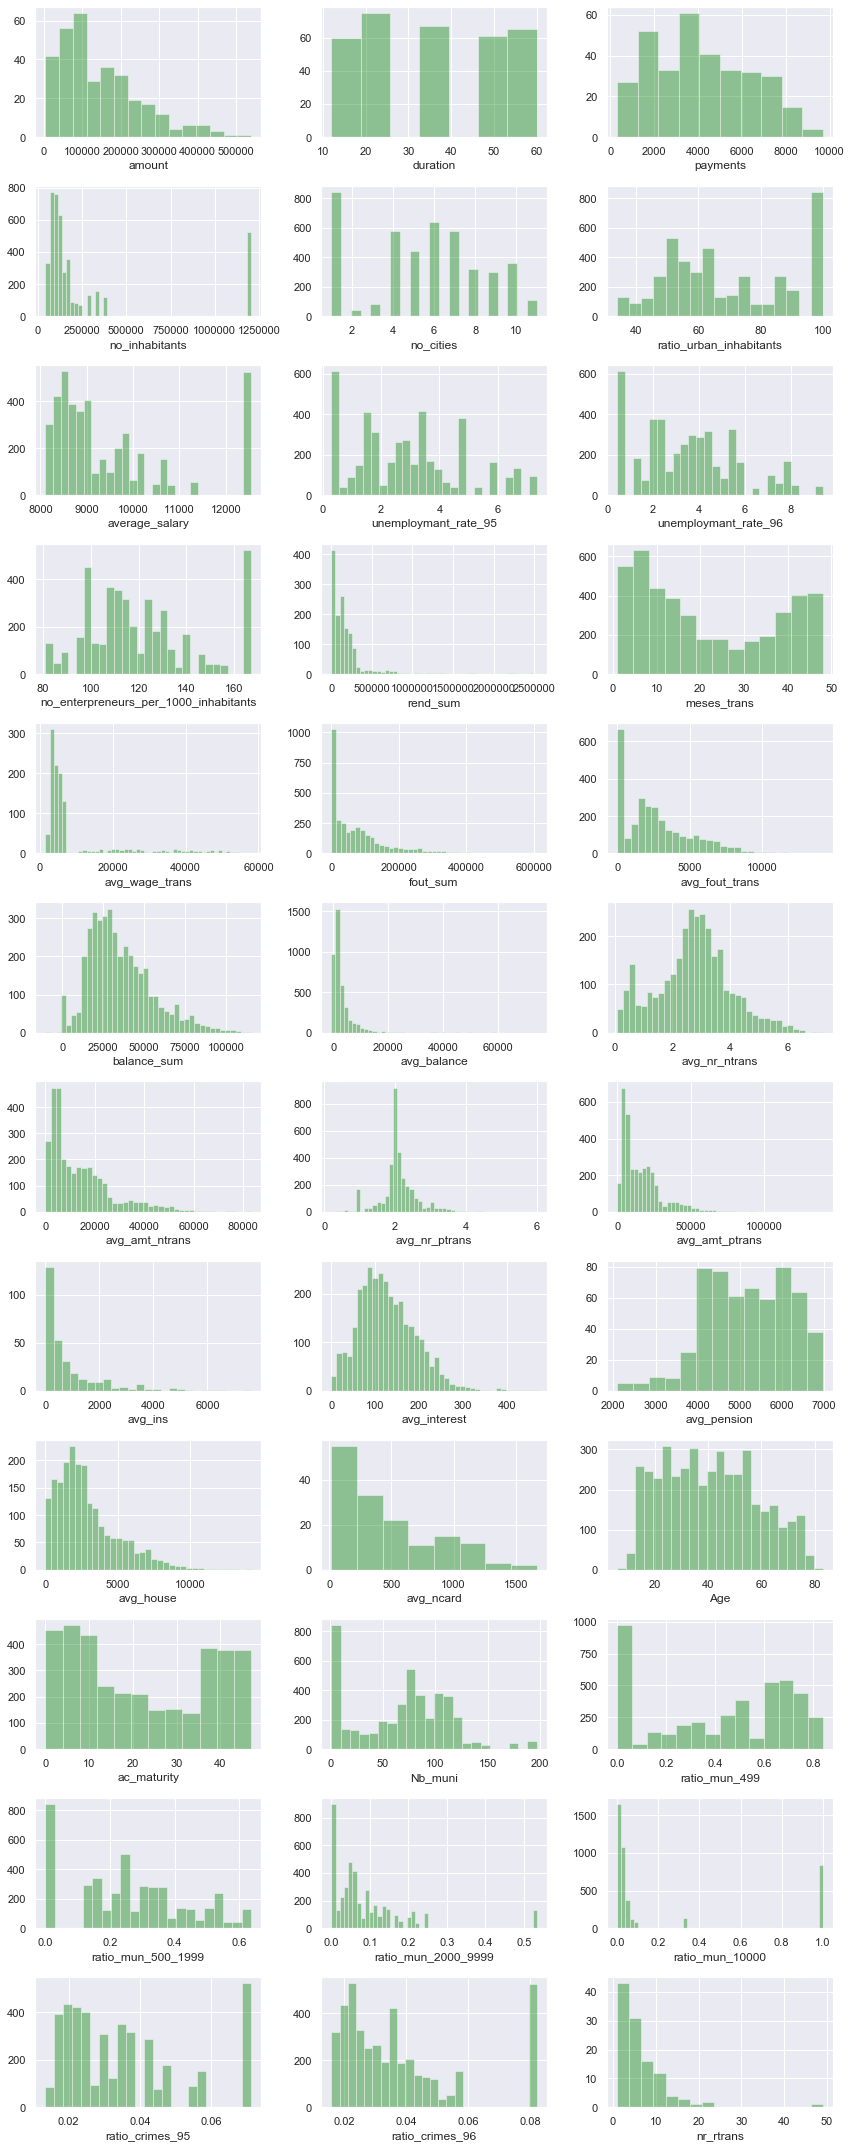

In [84]:
fig, axes = plt.subplots(math.ceil(len(client_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(client_num.columns):
        sns.distplot(client_num[client_num.columns[i]].dropna(), kde=False, color="green", ax=ax)

#axes.flat[-2].set_visible(False)
#axes.flat[-1].set_visible(False)
fig.tight_layout()

### Outliers

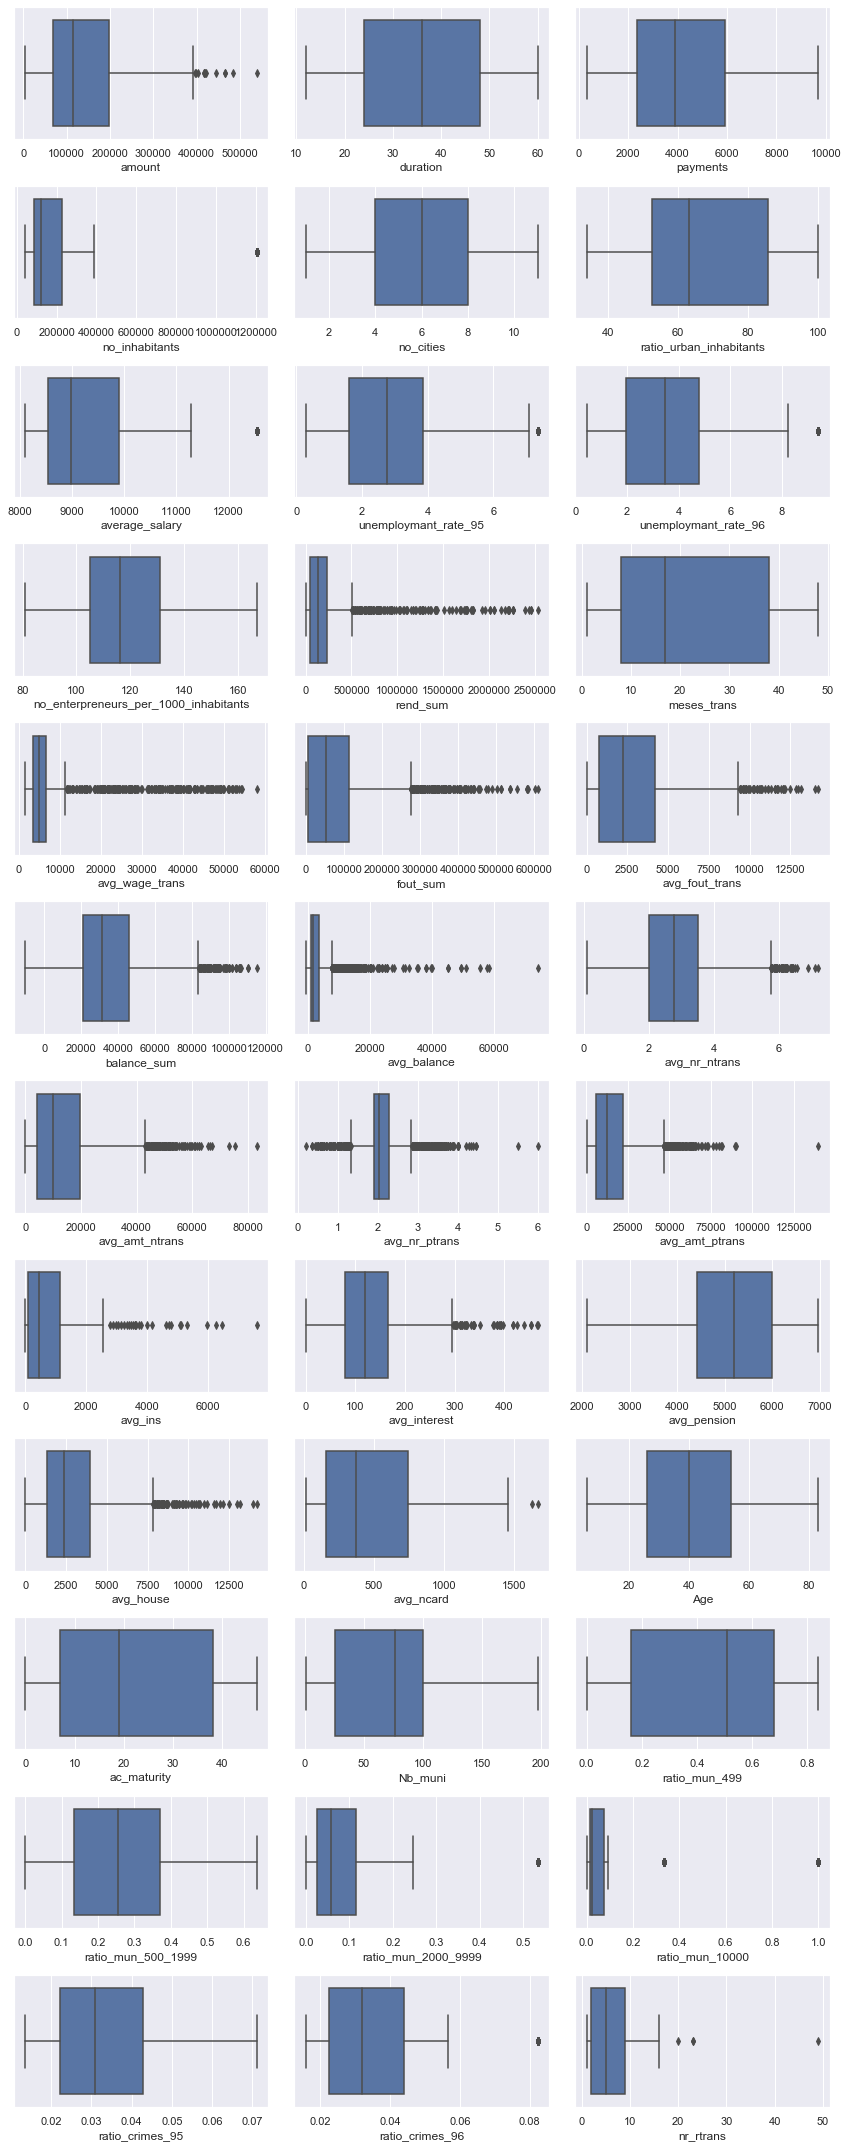

In [85]:
fig, axes = plt.subplots(math.ceil(len(client_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(client_num.columns):
        sns.boxplot(x=client_num.columns[i], data=client_num, ax=ax)

#axes.flat[-2].set_visible(False)
#axes.flat[-1].set_visible(False)
fig.tight_layout()

In [88]:
print('Distritos com outliers em nr habitantes:',
client_final.loc[client_final.no_inhabitants>1000000,'name'].unique())

Distritos com outliers em nr habitantes: ['Hl.m. Praha']


In [89]:
print('Distritos com outliers em altos salários médios:',
client_final.loc[client_final.average_salary>12000,'name'].unique())

Distritos com outliers em altos salários médios: ['Hl.m. Praha']


In [90]:
print('Distritos com outliers em taxa de desemprego 95:',
client_final.loc[client_final.unemploymant_rate_95>7,'name'].unique())

Distritos com outliers em taxa de desemprego 95: ['Louny' 'Most']


In [91]:
print('Distritos com outliers em taxa de desemprego 96:',
client_final.loc[client_final.unemploymant_rate_96>8.5,'name'].unique())

Distritos com outliers em taxa de desemprego 96: ['Most']


In [92]:
print('Distritos com outliers em nr municipios com nr hab entre 2000 e 9999:',
client_final.loc[client_final.ratio_mun_2000_9999>0.4,'name'].unique())

Distritos com outliers em nr municipios com nr hab entre 2000 e 9999: ['Karvina']


In [93]:
print('Distritos com outliers em nr municipios com nr hab > 9999:',
client_final.loc[client_final.ratio_mun_10000>0.2,'name'].unique())

Distritos com outliers em nr municipios com nr hab > 9999: ['Hl.m. Praha' 'Brno - mesto' 'Ostrava - mesto' 'Karvina' 'Plzen - mesto']


In [94]:
print('Distrito que se destaca pelo aumento da criminalidade em 96:',
client_final.loc[client_final.ratio_crimes_96>0.06,'name'].unique())

Distrito que se destaca pelo aumento da criminalidade em 96: ['Hl.m. Praha']


#### Distritos interessantes

In [102]:
distritos=['Hl.m. Praha', 'Brno - mesto', 'Ostrava - mesto', 'Karvina', 'Plzen - mesto', 'Louny', 'Most']
client_final.loc[client_final.name.isin(distritos),'district_new']=client_final.loc[client_final.name.isin(distritos),'name']
client_final.loc[~client_final.name.isin(distritos),'district_new']='Other'

In [103]:
#após os 10 anos de idade já podem criar conta como owner
client_final.loc[client_final.Age<10,'type_disp'].unique()
client_final.loc[client_final.Age<11,'type_disp'].unique()

array(['DISPONENT', 'OWNER'], dtype=object)

## Categorical plots

In [95]:
client_cat=client_final.select_dtypes(include=['object'])

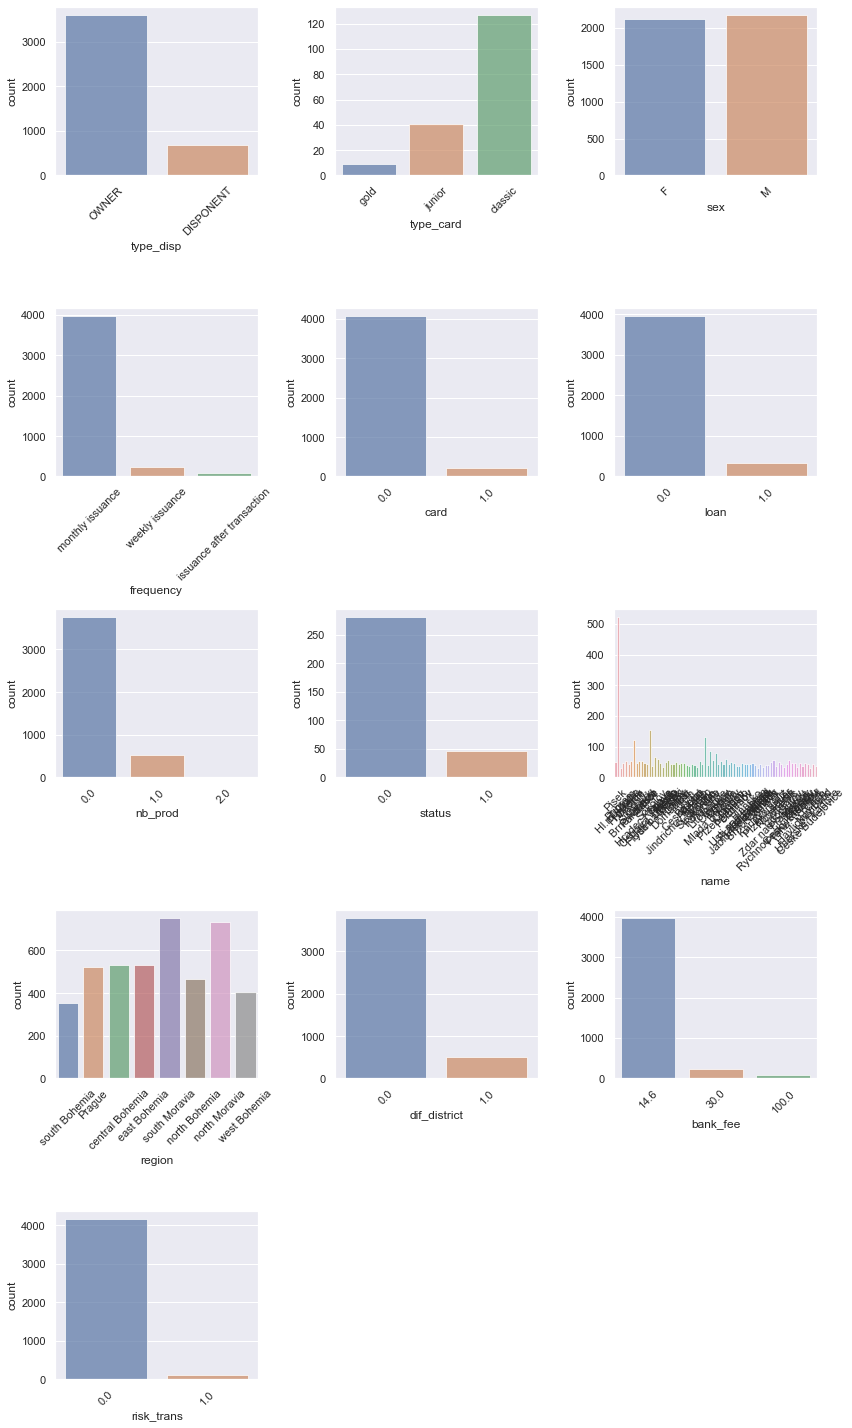

In [98]:
fig, axes = plt.subplots(math.ceil(len(client_cat.columns) / 3), 3, figsize=(12, 20))

for i, ax in enumerate(fig.axes):
    if i < len(client_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=client_cat.columns[i], data=client_cat, alpha=0.7, ax=ax)

axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
fig.tight_layout()

## Cruzamento com risco

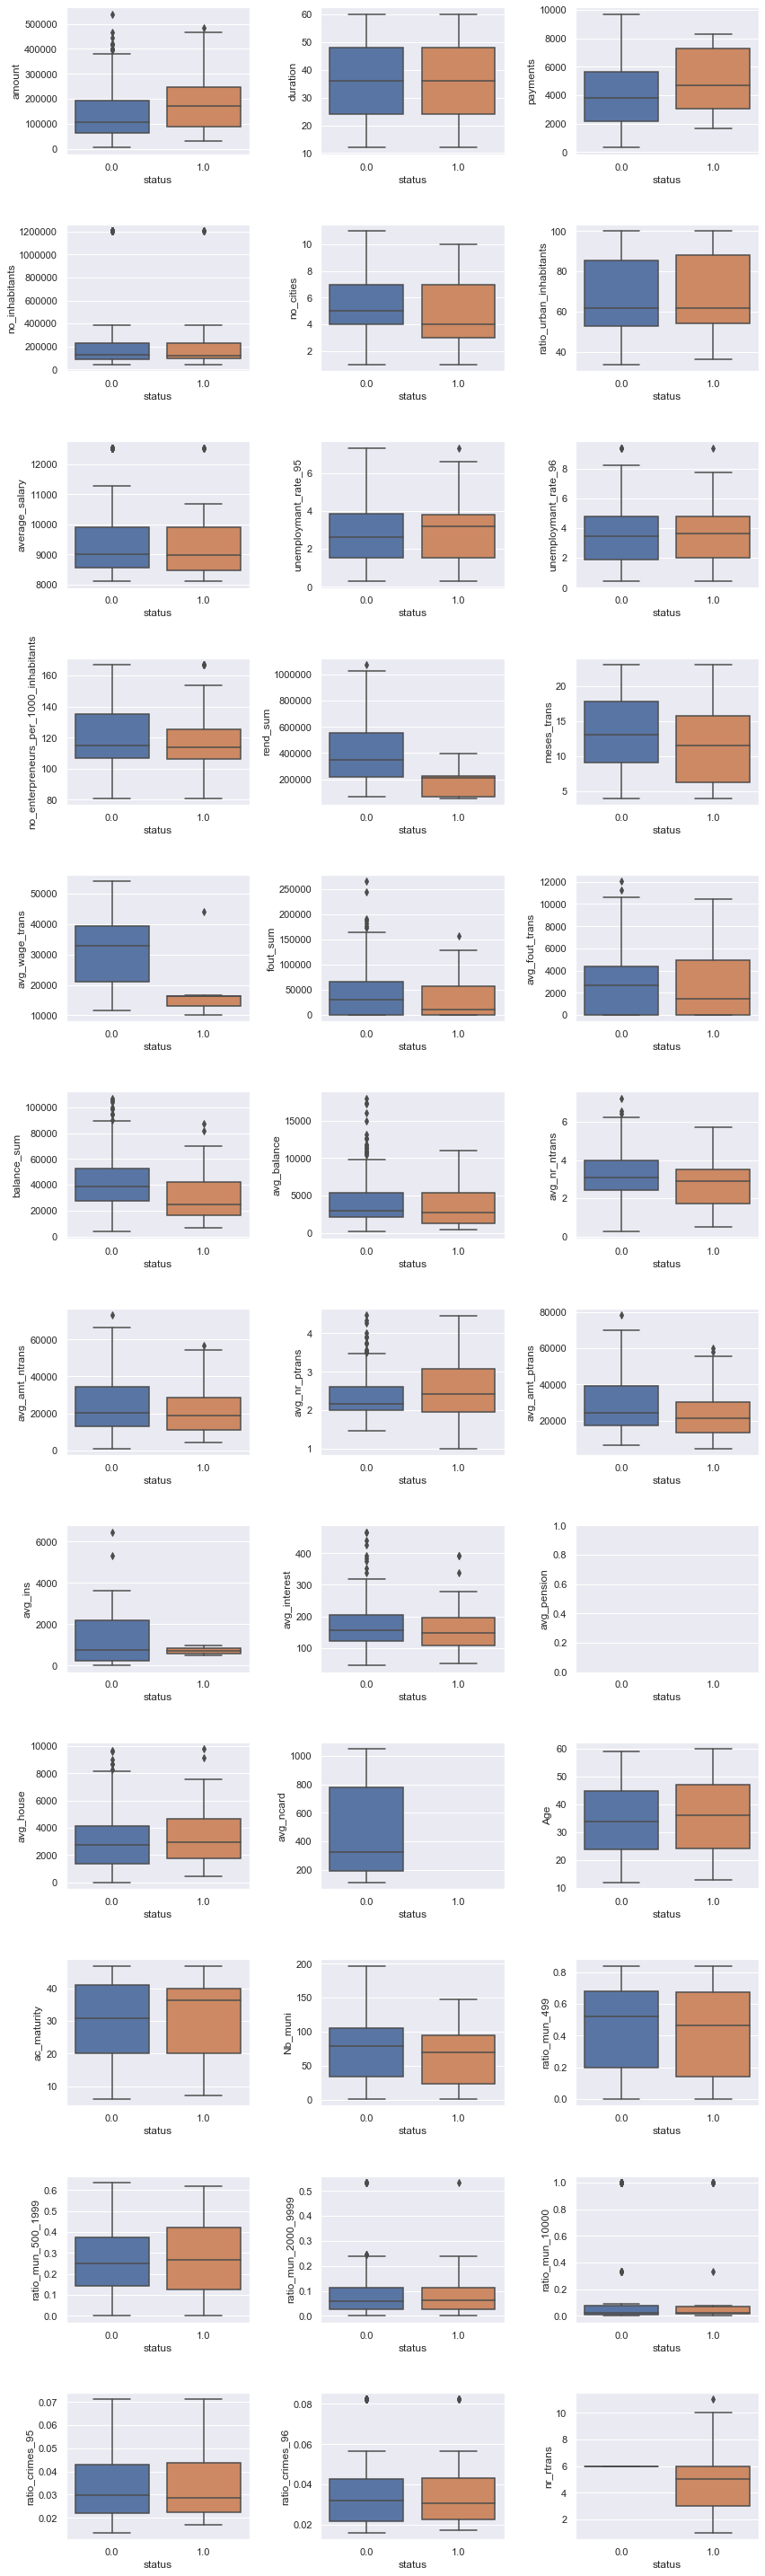

In [99]:
fig, axes = plt.subplots(math.ceil(len(client_num.columns) / 3), 3, figsize=(12, 40))

for i, ax in enumerate(fig.axes):
    if i < len(client_num.columns):
        sns.boxplot(x='status', y=client_num.columns[i], data=client_final, ax=ax)

#axes.flat[-1].set_visible(False)
fig.tight_layout()

In [100]:
client_cat.columns

Index(['type_disp', 'type_card', 'sex', 'frequency', 'card', 'loan', 'nb_prod',
       'status', 'name', 'region', 'dif_district', 'bank_fee', 'risk_trans'],
      dtype='object')

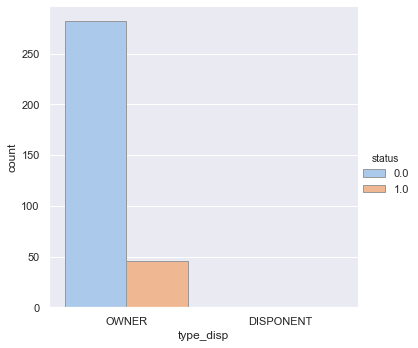

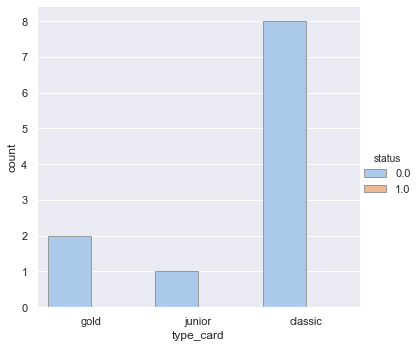

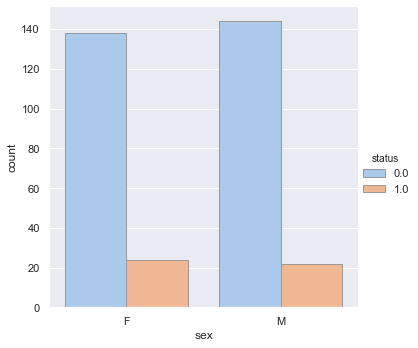

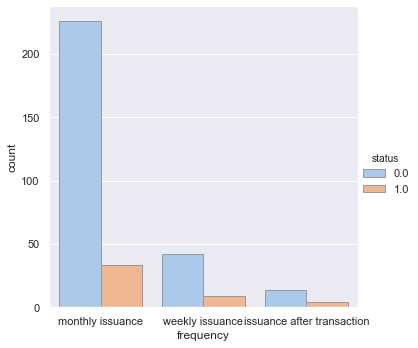

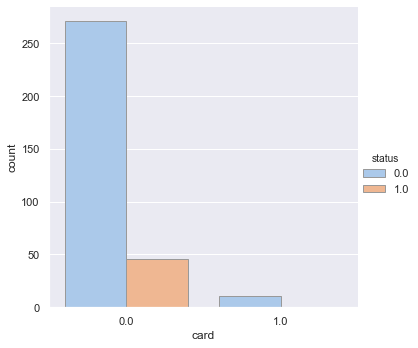

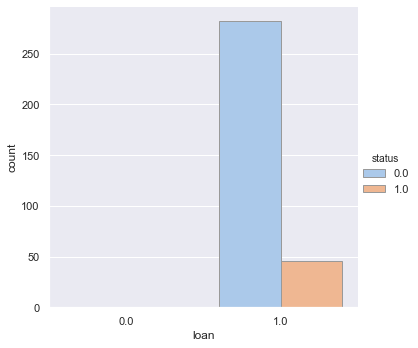

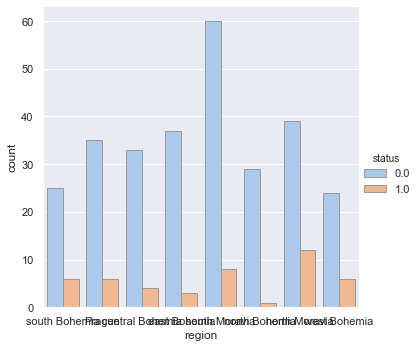

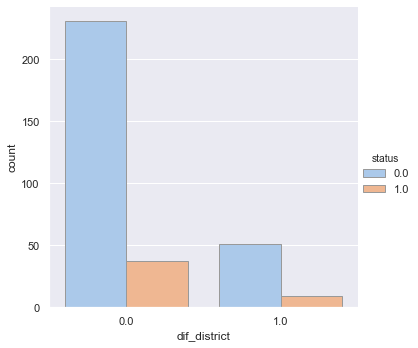

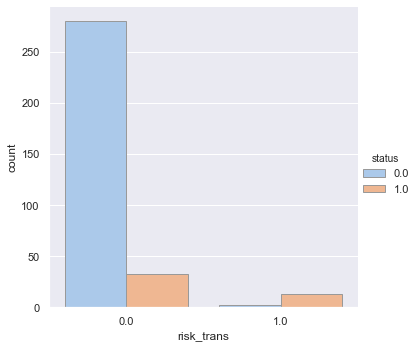

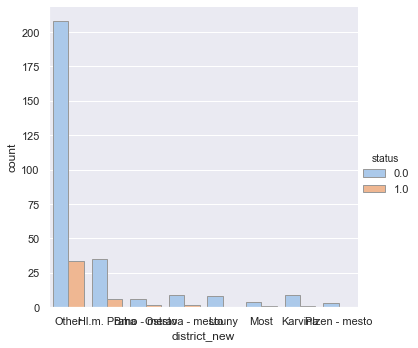

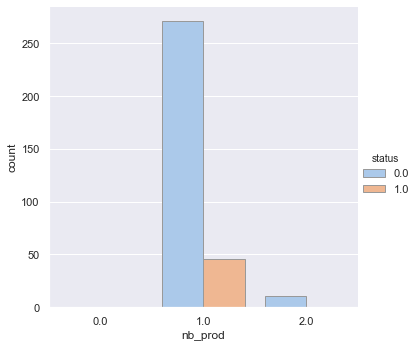

In [104]:
cat_var=['type_disp', 'type_card', 'sex', 'frequency', 'card', 'loan', 
       'region', 'dif_district', 'risk_trans', 'district_new','nb_prod']

for i, ax in enumerate(fig.axes):
    if i < len(cat_var):
        sns.catplot(x=cat_var[i], hue="status", kind="count",
            palette="pastel", edgecolor=".6",
            data=client_final)

fig.tight_layout()

## Correlações

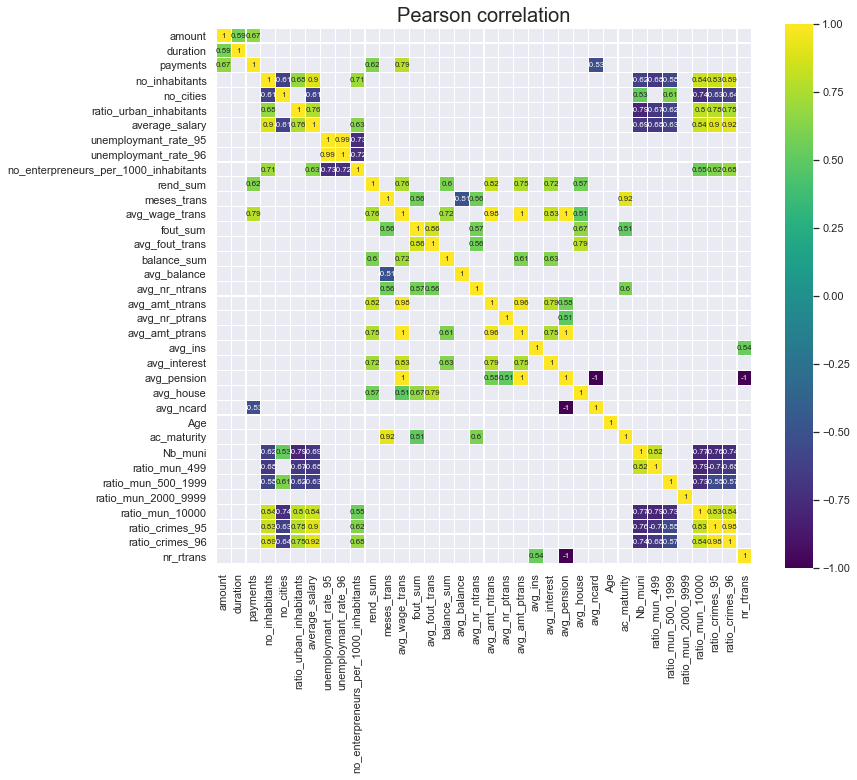

In [105]:
corr = client_num.corr()
plt.figure(figsize=(12, 10))
plt.title('Pearson correlation', fontsize=20)

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

# Bases finais

In [102]:
descriptive=client_final.copy()
predictive_train=client_final.loc[(client_final.loan==1) & (client_final.loan_date<'1996-01-01') & (client_final.type_disp=='OWNER')]
predictive_test=client_final.loc[(client_final.loan==1) & (client_final.loan_date>='1996-01-01') & (client_final.type_disp=='OWNER')]

In [103]:
stit=client_final.loc[client_final.type_disp!='OWNER','account_id'].unique()

In [104]:
predictive_train.loc[predictive_train.account_id.isin(stit),'2tit']=1
predictive_train.loc[~predictive_train.account_id.isin(stit),'2tit']=0

predictive_test.loc[predictive_test.account_id.isin(stit),'2tit']=1
predictive_test.loc[~predictive_test.account_id.isin(stit),'2tit']=0

C:\Users\Fabio\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Fabio\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [105]:
descriptive.to_parquet('descriptive.gzip',compression='gzip') 
predictive_train.to_parquet('predictive_train.gzip',compression='gzip') 
predictive_test.to_parquet('predictive_test.gzip',compression='gzip') 

## Análise temporal

In [106]:
client_final['generation_ac']= client_final['ac_date'].dt.to_period('M').dt.strftime('%Y-%m-01')

In [107]:
Nb_ac=client_final.loc[client_final.type_disp=='OWNER'].groupby('generation_ac')['account_id'].count().reset_index()

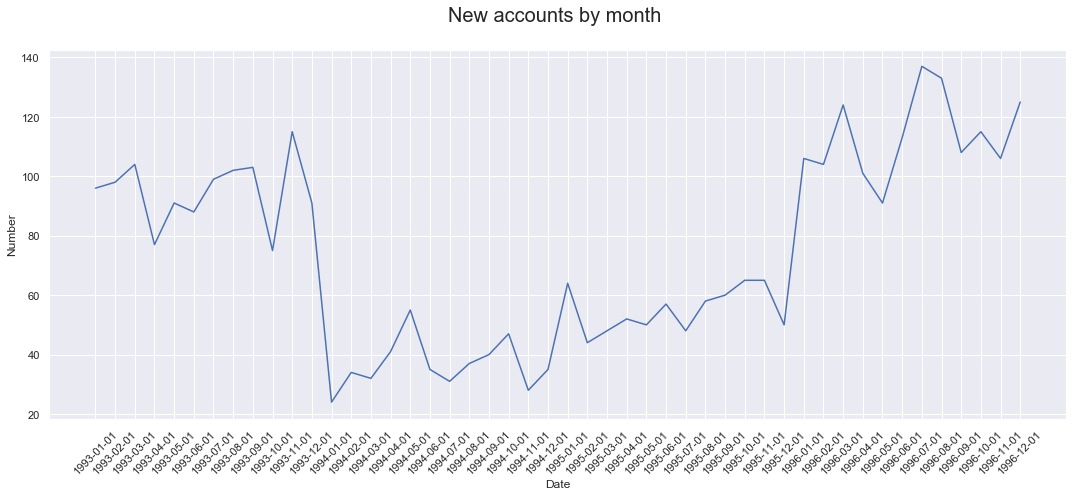

In [108]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x="generation_ac", y="account_id", data=Nb_ac, ax=ax)

ax.set(xlabel="Date",
       ylabel="Number",
      )
ax.set_title("New accounts by month \n",fontsize=20)
sns.set_context("paper")

plt.setp(ax.get_xticklabels(), rotation=45)
#plt.xticks(plt.xticks()[0], Nb_ac.generation_ac, rotation=70)
#ax.format_xdata = mdates.DateFormatter('%Y')
fig.tight_layout()

In [109]:
client_final['generation_loan']= client_final['loan_date'].dt.to_period('M').dt.strftime('%Y-%m-01')
Nb_loan=client_final.loc[(client_final.type_disp=='OWNER')&(client_final.loan==1)].groupby('generation_loan')['account_id'].count().reset_index()

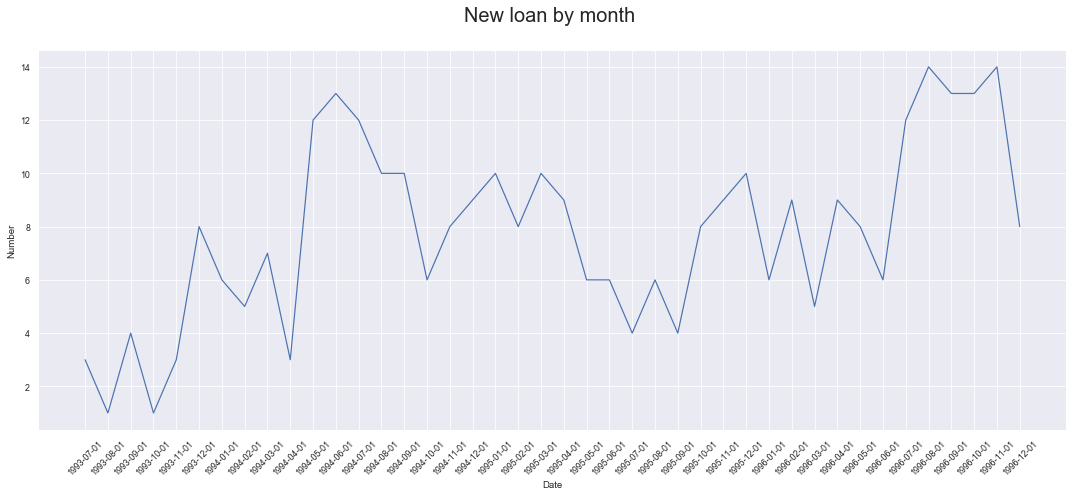

In [110]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x="generation_loan", y="account_id", data=Nb_loan, ax=ax)

ax.set(xlabel="Date",
       ylabel="Number",
      )
ax.set_title("New loan by month \n",fontsize=20)
sns.set_context("paper")

plt.setp(ax.get_xticklabels(), rotation=45)
#plt.xticks(plt.xticks()[0], Nb_ac.generation_ac, rotation=70)
#ax.format_xdata = mdates.DateFormatter('%Y')
fig.tight_layout()

In [111]:
Nb_risk_loan=client_final.loc[(client_final.type_disp=='OWNER')&(client_final.loan==1)&(client_final.status==1)].groupby('generation_loan')['account_id'].count().reset_index()

In [112]:
risco_loan=Nb_loan.merge(Nb_risk_loan,on='generation_loan',how='left').fillna(0)
risco_loan['generation_yloan']= risco_loan['generation_loan'].str[0:4]

In [113]:
risco_loan2=risco_loan.groupby('generation_yloan').agg({'account_id_x':'sum','account_id_y':'sum'}).reset_index()

In [114]:
risco_loan2['risk_rate']=risco_loan2.account_id_y/risco_loan2.account_id_x

In [116]:
risco_loan2.columns=['generation','loan_nr','risk_nr','risk_rate']
risco_loan2

,generation,loan_nr,risk_nr,risk_rate
0,1993,20,4.0,0.200000
1,1994,101,14.0,0.138614
2,1995,90,12.0,0.133333
3,1996,117,16.0,0.136752


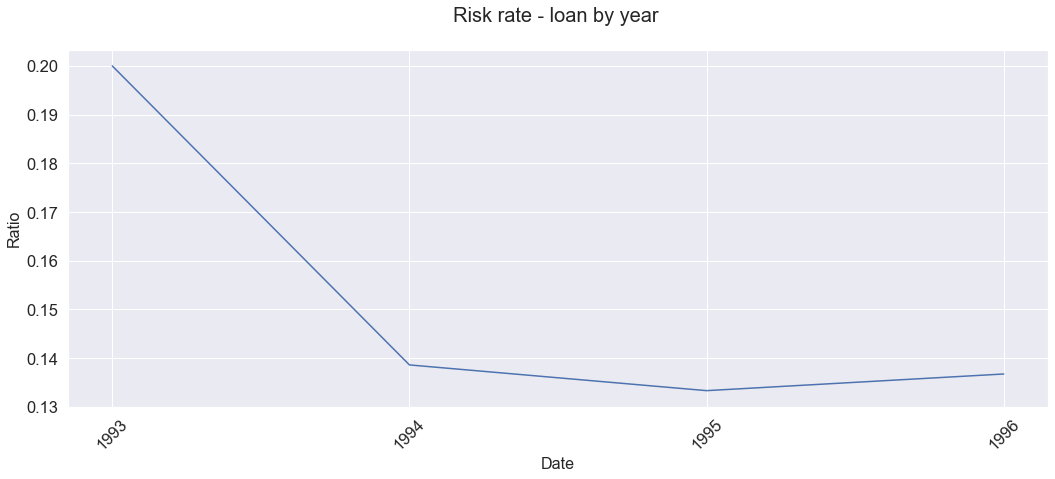

In [151]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x="generation", y="risk_rate", data=risco_loan2, ax=ax)

ax.set_xlabel("Date",fontsize=16)
ax.set_ylabel("Ratio",fontsize=16)
       
ax.set_title("Risk rate - loan by year \n",fontsize=20)
sns.set_context("paper")

plt.setp(ax.get_xticklabels(), rotation=45)
sns.set(font_scale=1.5)
#plt.xticks(plt.xticks()[0], Nb_ac.generation_ac, rotation=70)
#ax.format_xdata = mdates.DateFormatter('%Y')
fig.tight_layout()

In [146]:
predictive_train.status.sum()/len(predictive_train.status)

0.14218009478672985